In [144]:
import numpy as np
from scipy import signal
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax


In [354]:
# Set seed for reproducibility
np.random.seed(0)

# Generate time samples
t = np.linspace(0, 200, 1000)

# Sources
source_1 = np.sin(t*2)
source_2 = 2 * (1.9*t % (2 * np.pi)) / (2 * np.pi) - 1  # Sawtooth wave approximation
# source_2 = signal.sawtooth(t * 1.9)
source_3 = np.random.random(len(t))

# Stack sources to form S matrix
S = np.array([source_1, source_2, source_3])

# Mixing process
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signals
X = A @ S

# Number of sources, samples, and signals
n_sources, n_samples = S.shape
n_signals = X.shape[0]


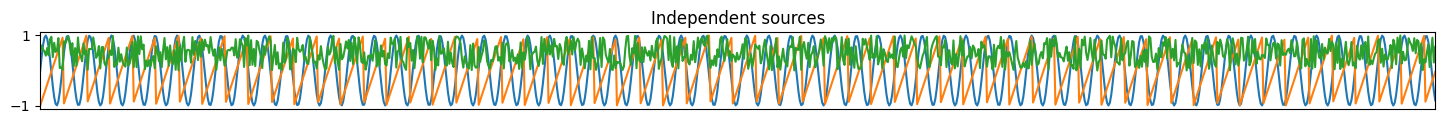

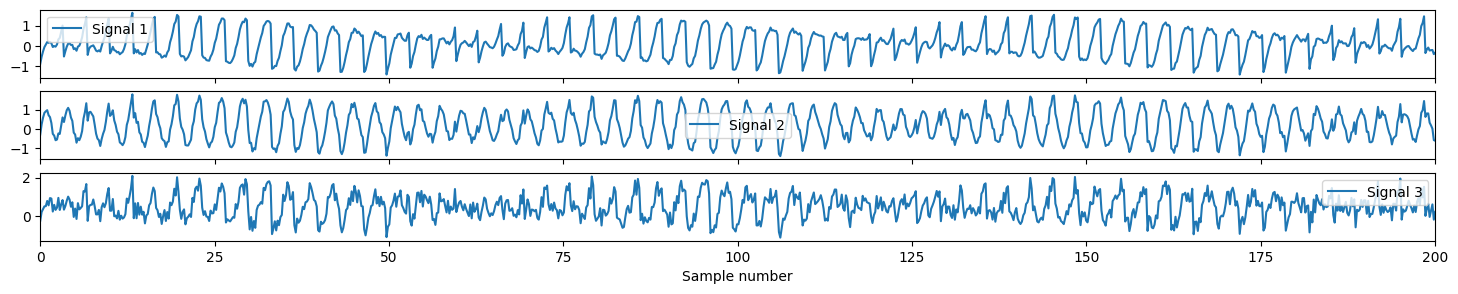

In [355]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 1])
ax.plot(t, S.T)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(t[0], t[-1])
ax.tick_params()
ax.set_title('Independent sources')

fig, ax = plt.subplots(n_signals, 1, figsize=[18, 3], sharex=True)
for signal_number, observed_signal in enumerate(X):
    ax[signal_number].plot(t, X[signal_number], label=f"Signal {signal_number + 1}")
    ax[signal_number].tick_params()
    ax[signal_number].legend()

ax[-1].set_xlabel('Sample number')
ax[-1].set_xlim(t[0], t[-1])
plt.show()

## Importing needed functions.


In [356]:
%cd independent_component_analysis

[WinError 2] Le fichier spécifié est introuvable: 'independent_component_analysis'
c:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis


c:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis\.venv\lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [357]:
%pwd

'c:\\Users\\TRETEC\\Documents\\MVA\\S1\\[IPGM] Introduction to probabilistic graphical models\\Projet\\independent_component_analysis'

In [358]:
from mva_independent_component_analysis.utils.preprocessing import centering_and_whitening
from mva_independent_component_analysis.fast_ica.fastica import fast_ica as fastica
from mva_independent_component_analysis.fast_ica.discriminating_fastica import fast_ica as discriminating_fastica
from mva_independent_component_analysis.mle_ica.gradient import gradient_ica

## 1. Fast ICA algorithm as an approx negentropy maximisation problem

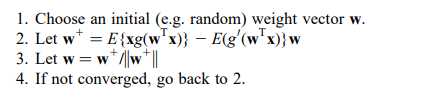


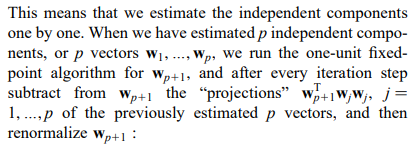

In [434]:
def fastIcaNour(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape #(m,n)

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy() #(1,p)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            while (i < iterations):

                # Dot product of weight and signal
                wTx = np.dot(w, signals) # (1,p)(p,n)=(1,n)

                # Pass w*s into contrast function g
                gwTx = np.tanh(wTx * alpha).T #(n,1)

                # Pass w*s into g prime
                g_wTx = (1 - np.square(np.tanh(wTx))) * alpha #(n,1)

                # Update weights
                w_ = (signals * gwTx.T).mean(axis=1) - g_wTx.mean() * w.squeeze()

                # Decorrelate weights
                w_ = w_ - np.dot(np.dot(w_, W[:c].T), W[:c])

                # Normalize
                w_ = w_ / np.sqrt((w_ ** 2).sum())

                w_ /= np.linalg.norm(w_)

                if np.abs(np.abs(w_.T@w) - 1) < thresh:
                  break

                # Update weights
                w = w_

                # Update counter
                i += 1

            W[c, :] = w
    return W

### Visualize properties of toy signals

To check if the properties discussed above also apply for our toy signals we will plot them accordingly.
As expected the source signals are distributed on a square for non-Gaussian random variables. Likewise the mixed signals form a parallelogram in the right plot of Figure 3 which shows that the mixed signals are not independent anymore.

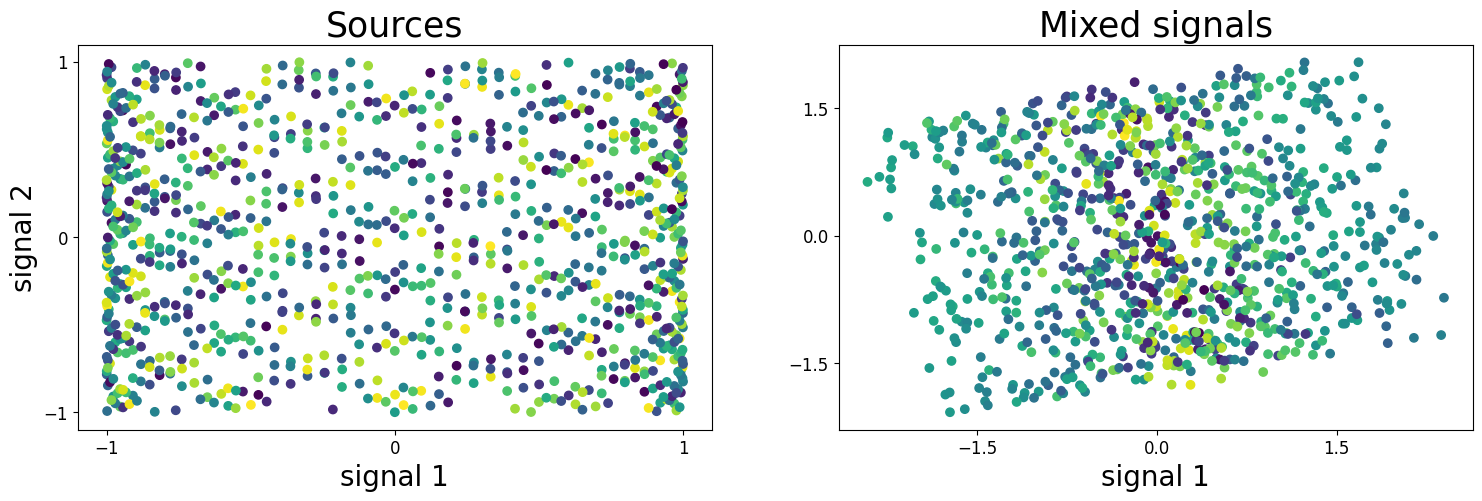

In [371]:
fig, ax = plt.subplots(1, 2, figsize=[18, 5])
ax[0].scatter(S[0], S[1], c=S[2])
ax[0].tick_params(labelsize=12)
ax[0].set_yticks([-1, 0, 1])
ax[0].set_xticks([-1, 0, 1])
ax[0].set_xlabel('signal 1', fontsize=20)
ax[0].set_ylabel('signal 2', fontsize=20)
ax[0].set_title('Sources', fontsize=25)

ax[1].scatter(X[0], X[1], c=X[2])
ax[1].tick_params(labelsize=12)
ax[1].set_yticks([-1.5, 0, 1.5])
ax[1].set_xticks([-1.5, 0, 1.5])
ax[1].set_xlabel('signal 1', fontsize=20)
ax[1].set_title('Mixed signals', fontsize=25)
plt.show()

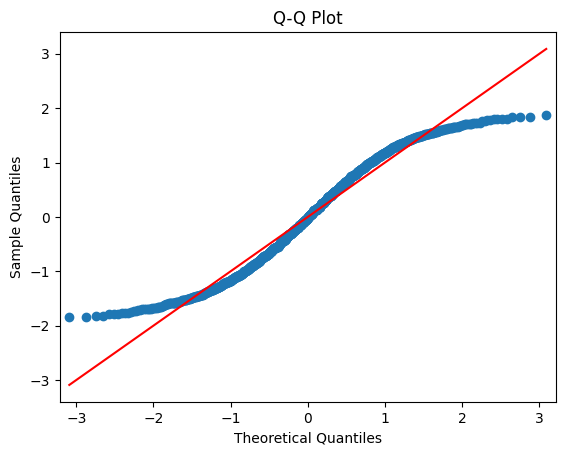

In [372]:
Sw, _, _ = centering_and_whitening(S)
import statsmodels.api as sm
# Create a Q-Q plot
sm.qqplot(Sw[1], line='s')
plt.title('Q-Q Plot')
plt.show()


In [ ]:
plt.hist(Sw[1], bins=30, color='blue', edgecolor='black')


### Pre-processing

So... before we run the ICA we need to do the pre-processing.

In [363]:
# Center & whiten signals
X, meanX, whiteM = centering_and_whitening(X)

### Running the ICA

In [364]:
import time

In [452]:
JAX_KEY = jax.random.PRNGKey(1337)
start_time = time.time()
W_fastIcaNour = fastIcaNour(X, 1, 1e-8, 5000) #Nour's method.
end_time = time.time()
print(f'Nour:{end_time-start_time}')
start_time=time.time()
W_fastIca = fastica(JAX_KEY, X, X.shape[0], 1e-8, jnp.tanh, 5000)  #Yvann's method
end_time=time.time()
print(f'Yvann:{end_time-start_time}')

W_fastIcaDiscriminating = discriminating_fastica(JAX_KEY, X, X.shape[0], 1e-8, 5000)  #Fast ICA discriminating between sub and super gaussian sources
W_gradientdescent = gradient_ica(JAX_KEY, X, X.shape[0], 1e-8, 500000, g=None)  #Gradient descent with kurtosis rule
#Un-mix signals using
unMixed = np.dot(W_fastIcaNour,X)-meanX
# Subtract mean

Nour:0.021744728088378906
Yvann:0.628373384475708


fastIca Nour


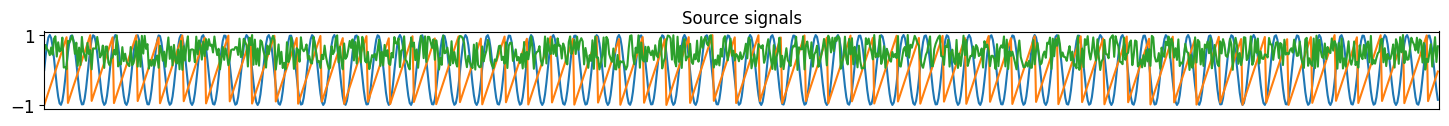

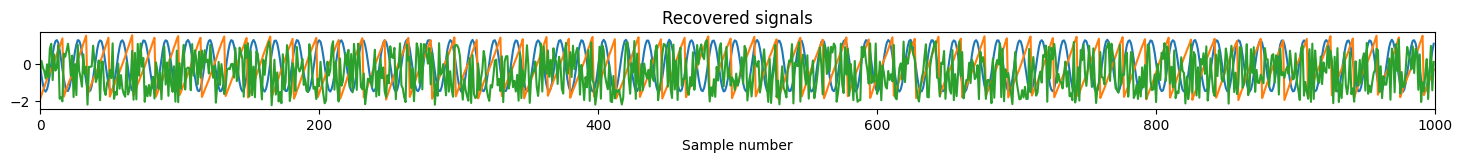

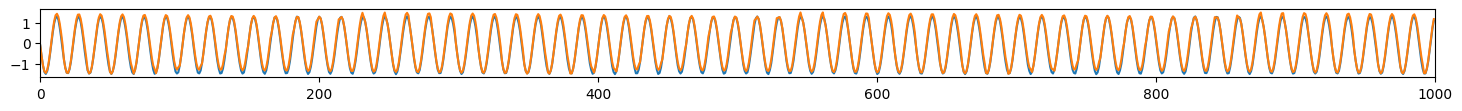

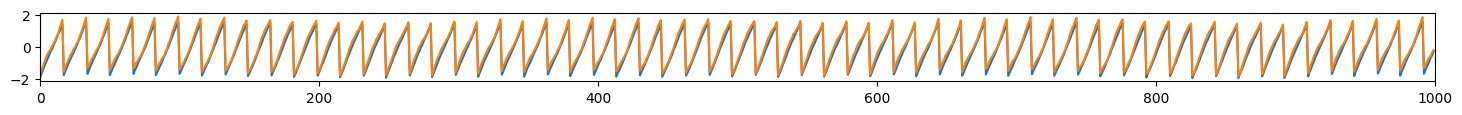

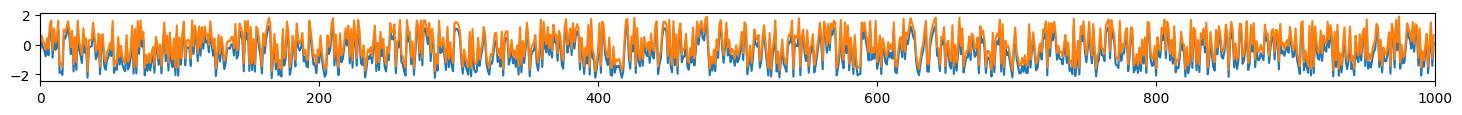

fastIca


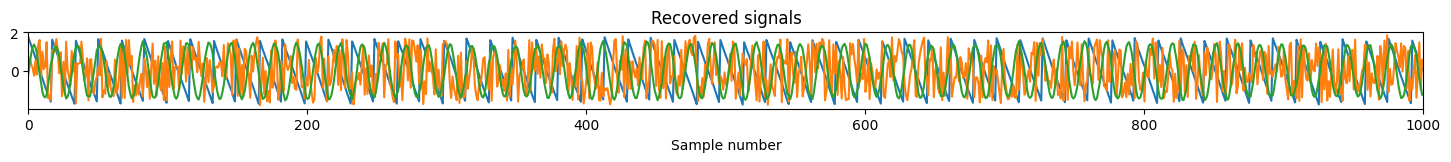

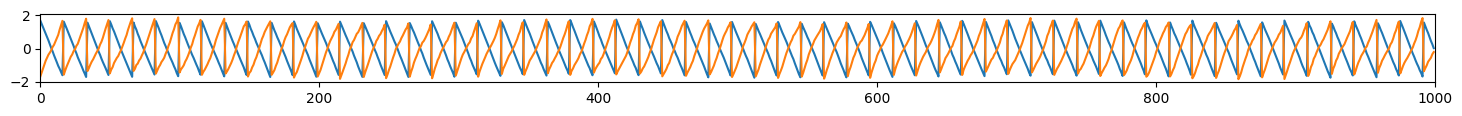

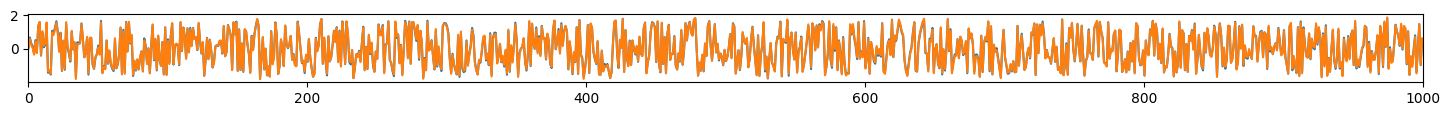

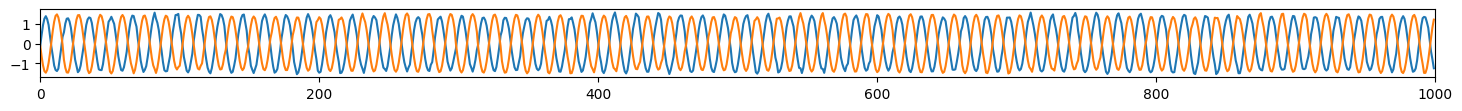

In [450]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18,1])
ax.plot(S.T)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals')
ax.set_xlim(0, S.shape[1])  #ns[-1] depends


def plot_recovered_signals(unMixed):
    fig, ax = plt.subplots(1, 1, figsize=[18,1])
    ax.plot((unMixed).T, label='Recovered signals')
    ax.set_xlabel('Sample number')
    ax.set_title('Recovered signals')
    ax.set_xlim(0, S.shape[1])

    Sw, _, _ = centering_and_whitening(S)

    for i in range(n_sources):
        perm = jnp.argmax(jnp.abs(unMixed[i,:] @ Sw.T))
        plt.figure(figsize=(18,3))
        plt.subplot(3,1,i+1)
        plt.plot(unMixed[i,:].T)
        plt.plot(Sw[perm].T)
        plt.xlim(0, S.shape[1])
        plt.show()
    # ax.set_ylim(-1.5, 1.5)


print(f"fastIca Nour")
plot_recovered_signals(unMixed)
print(f"fastIca")
plot_recovered_signals(W_fastIca@X)
# print(f"fastIca discriminating between super and subgaussian sources")
# plot_recovered_signals((W_fastIcaDiscriminating@X))
# print(f"Gradient descent with kurtosis rule")
# plot_recovered_signals((W_gradientdescent@X))

## Kurtosis

So finally lets check one last thing: The kurtosis of the signals.

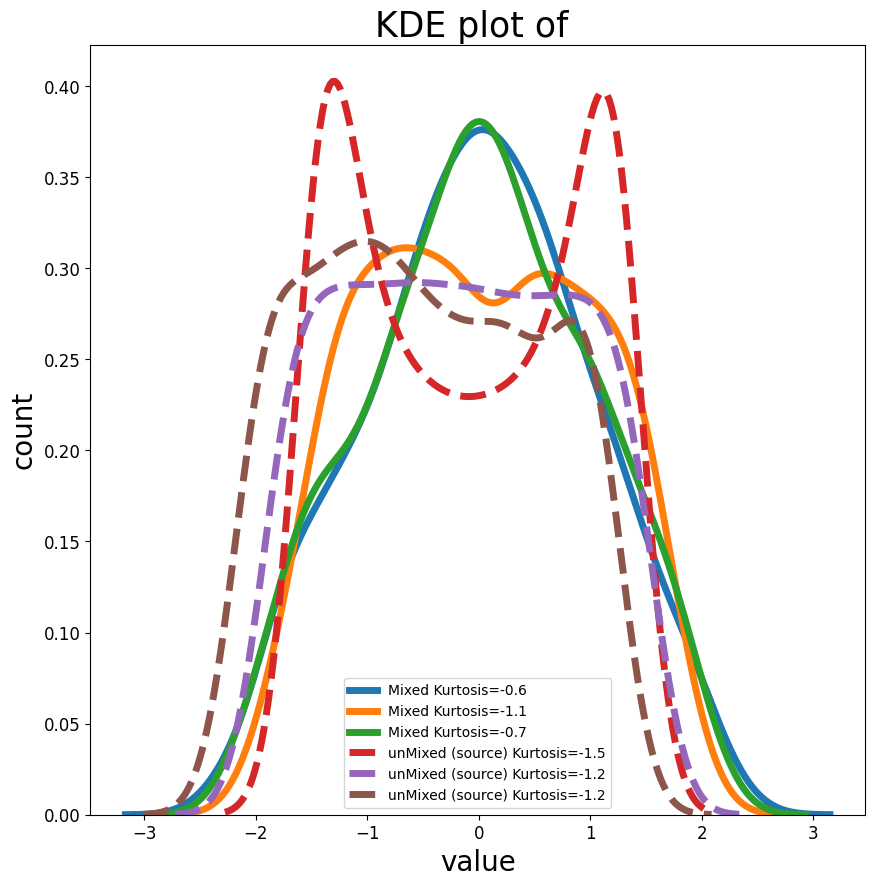

In [449]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(X.shape[0]):
    sns.kdeplot(X[i, :], lw=5, label='Mixed Kurtosis={}'.format(np.round(kurtosis(X[i, :]), decimals=1)))

for i in range(X.shape[0]):
    sns.kdeplot(unMixed[i, :], lw=5, ls='--',
                label='unMixed (source) Kurtosis={}'.format(np.around(kurtosis(unMixed[i, :]), decimals=1)))

ax.tick_params(labelsize=12)
ax.legend()

ax.set_xlabel('value', fontsize=20)
ax.set_ylabel('count', fontsize=20)
ax.set_title('KDE plot of ', fontsize=25)
plt.show()